<a href="https://colab.research.google.com/github/ssunwalka01/Invoice_OCR/blob/master/Invoice_OCR_Reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Invoice OCR Reader using Tesseract and Image Preprocessing**

Welcome to my notebook !! It will walk you step by step with the basic OCR reader for an invoice receipt.

**Outline**

- Reading Image
- Converting into Grayscale image
- Binarisation of image (I have used OTSU thresholding method)
- Making Text(Foreground) as White and background as Black
- Trying to find Bounding Boxes of Image for perspective transform using Houghline method
- Crop and Zoom desired part for feeding to pytesseract 
- Regex to extract matching text/fields

In [196]:
# import the necessary packages
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import sys
from google.colab.patches import cv2_imshow 
# using cv2_imshow in colab instead of cv2.imshow()

In [197]:
# Reading the image
image = cv2.imread("/content/sample(MB).jpeg")
image_copy = cv2.imread("/content/sample(MB).jpeg")

Showing GRAYSCALE IMAGE: 



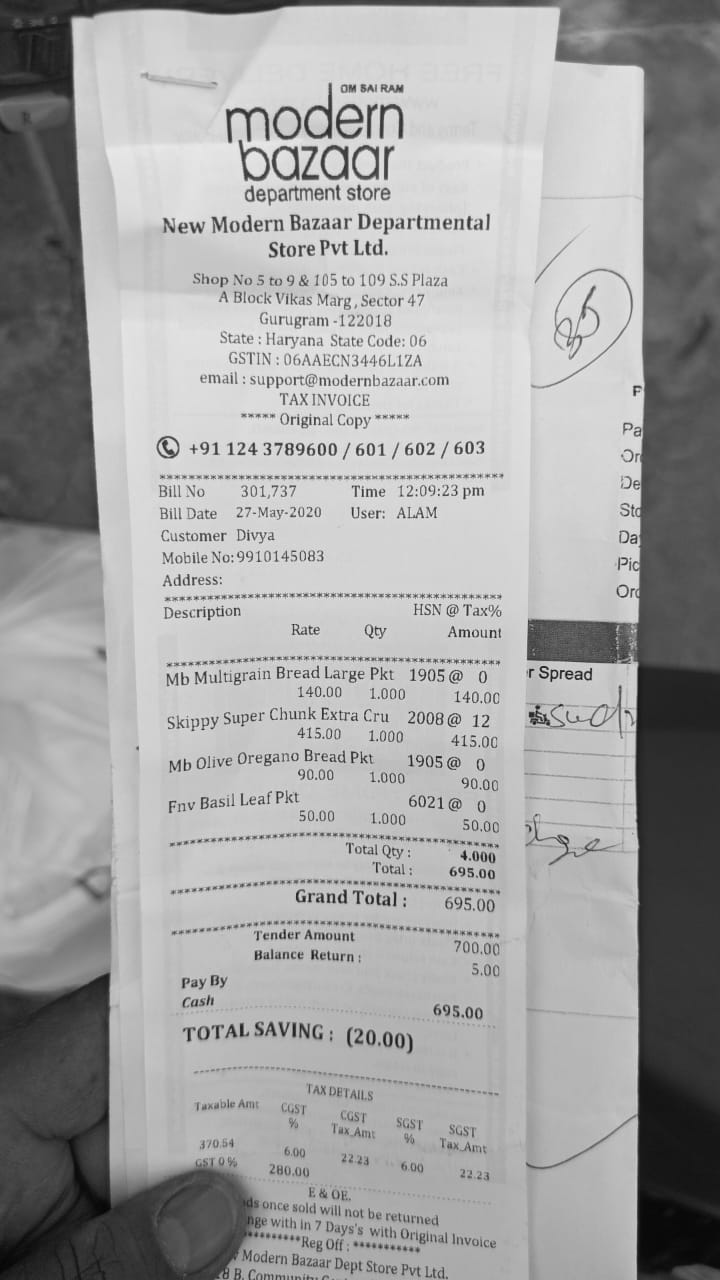

In [200]:
# Converting image into grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print("Showing GRAYSCALE IMAGE: \n")
cv2_imshow(grayscale_image)

Showing the BINARISED IMAGE:



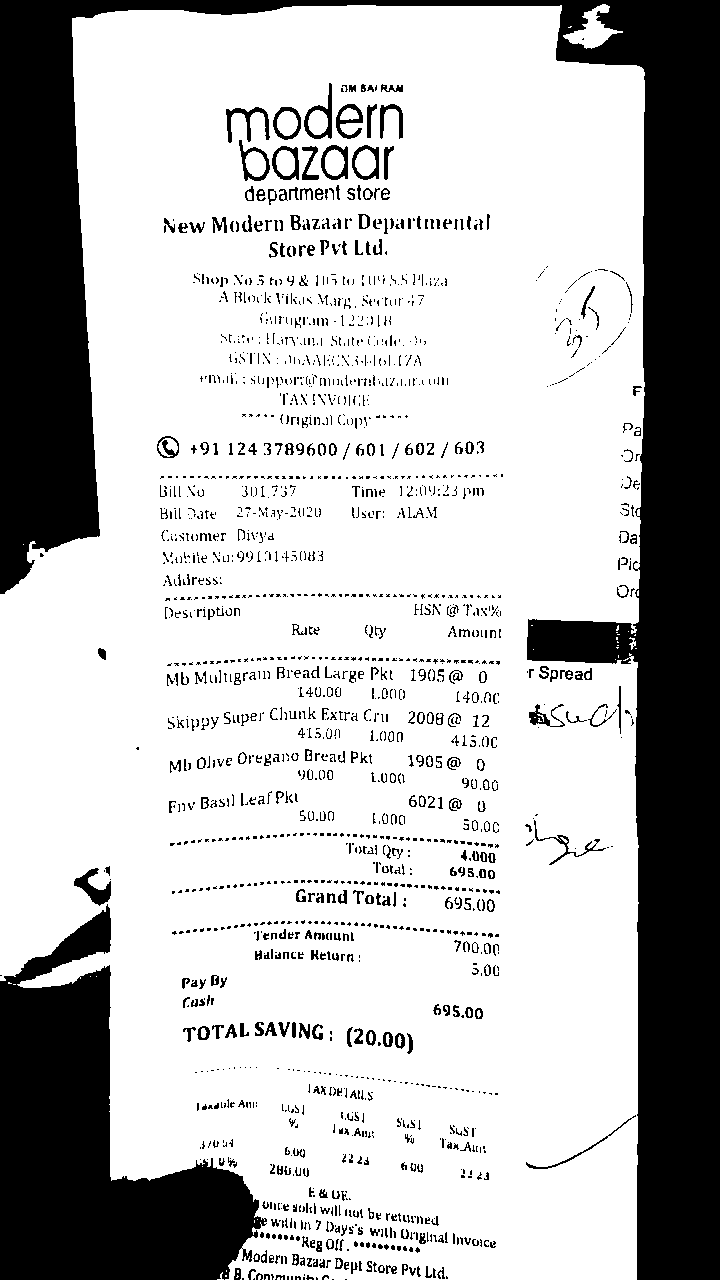

In [201]:
# Binarizing the image using otsu thresholding
ret, otsu_thresh_image = cv2.threshold(grayscale_image, 100, 255, cv2.THRESH_BINARY + 
                                            cv2.THRESH_OTSU)
print("Showing the BINARISED IMAGE:\n")
cv2_imshow(otsu_thresh_image)
# cv2.imwrite("otsu.jpeg", otsu_thresh_image)

In [202]:
# blurring image
cv2.GaussianBlur(grayscale_image, (3,3), 0, grayscale_image)

array([[39, 40, 40, ..., 89, 90, 91],
       [40, 40, 40, ..., 88, 90, 90],
       [42, 42, 41, ..., 88, 89, 90],
       ...,
       [27, 27, 27, ..., 83, 83, 83],
       [26, 26, 27, ..., 84, 84, 84],
       [26, 26, 27, ..., 85, 85, 85]], dtype=uint8)

In [203]:
# these constants are carefully picked here but we can always tweak them
MORPH = 9
CANNY = 84
HOUGH = 25

Showing the DILATED IMAGE after removing text: 



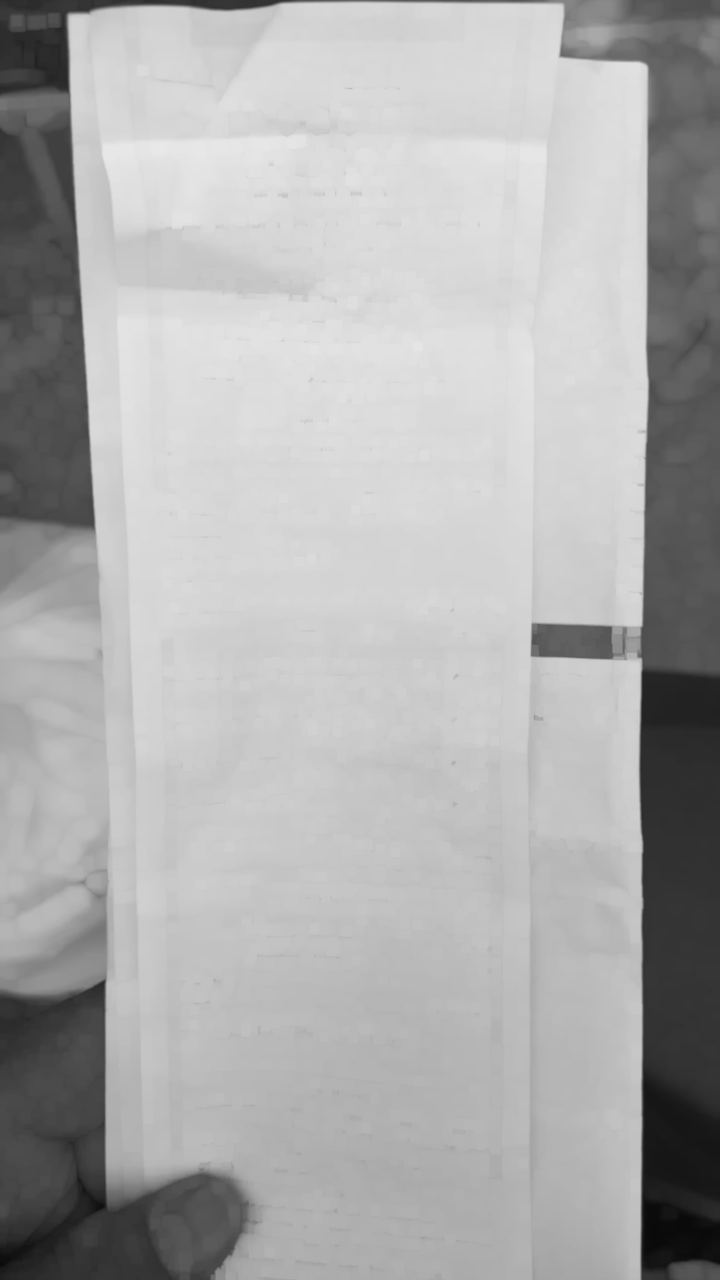

In [204]:
# this is to recognize white on white
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(MORPH,MORPH))
image_dilated = cv2.dilate(grayscale_image, kernel)
print("Showing the DILATED IMAGE after removing text: \n")
cv2_imshow(image_dilated)

Image after EDGE DETECTION:



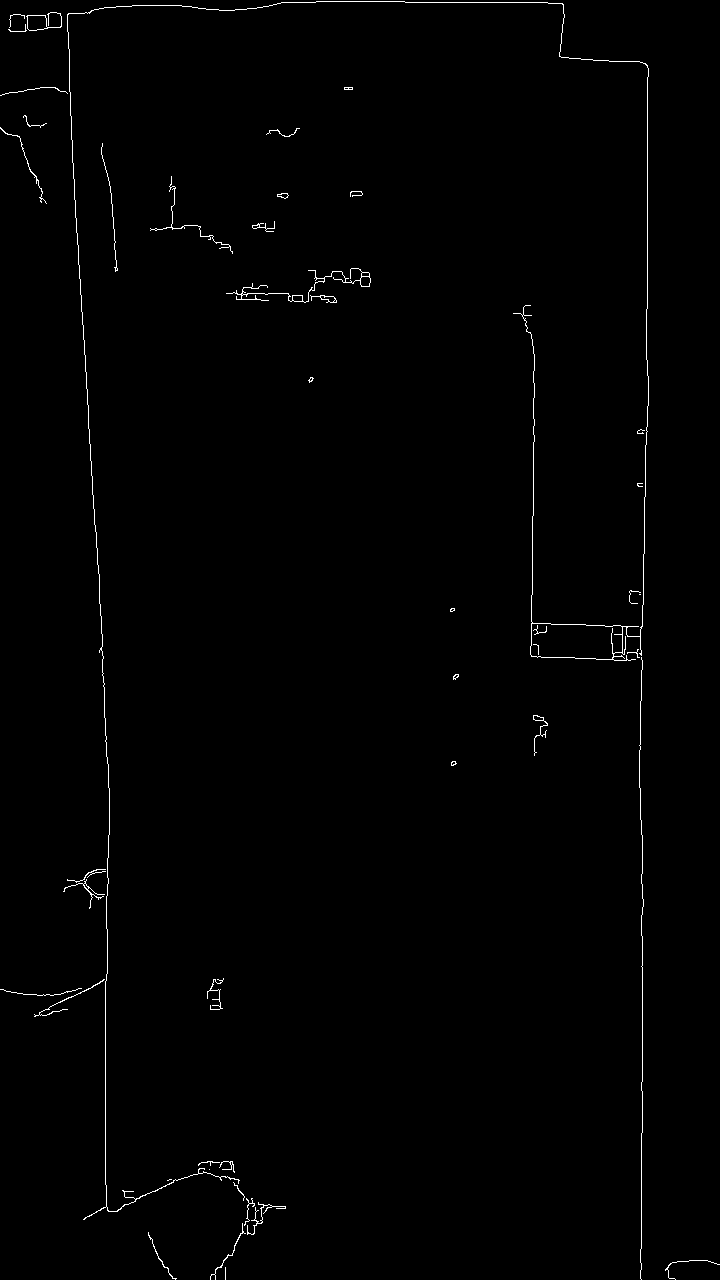

In [205]:
# Edge Detection
edges = cv2.Canny(image_dilated, 0, CANNY, apertureSize=3)
print("Image after EDGE DETECTION:\n")
cv2_imshow(edges)

In [206]:
# function to give text into white and background as black
def get_new(old):
    new = np.ones(old.shape, np.uint8)
    cv2.bitwise_not(new,new)
    return new

In [207]:
# using Houghline probabilistic method for Line Detection
lines = cv2.HoughLinesP(edges, 1,  3.14/180, HOUGH)
for line in lines[0]:
  cv2.line(edges, (line[0], line[1]), (line[2], line[3]),
           (255,0,0), 2, 8)

In [210]:
# finding contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
contours = filter(lambda cont: cv2.arcLength(cont, False) > 10, contours)
contours = filter(lambda cont: cv2.contourArea(cont) > 1000, contours)

#  NOTE : Here, we can tweak the filter criteria accordingly or can optimise the rule depending on various samples observation
#  field "10" arc length and "1000" area

In [211]:
# simplify contours down to polygons
rects = []
for cont in contours:
    rect = cv2.approxPolyDP(cont, 400, True).copy().reshape(-1, 2)
    rects.append(rect)
# Tweaking of 400 i.e. epsilon parameter can be more optimised with more samples/observations

In [212]:
rects
# list of coordinates that might make closed polygon

[array([[531, 624]], dtype=int32), array([[ 562,    3],
        [  67,   14],
        [  83, 1219],
        [  67,   15],
        [ 647,   66],
        [ 630,  660]], dtype=int32)]

In [213]:
# making a list of (x,y) pairs
coord_list = []
x= image.shape[0]
y = image.shape[1]
for i in range(0, len(rects)):

  for j in range(0, len(rects[i])):

    demo = rects[i][j].tolist()
    coord_list.append(demo)

In [214]:
coord_list

[[531, 624], [562, 3], [67, 14], [83, 1219], [67, 15], [647, 66], [630, 660]]

In [215]:
coord_list = np.array(coord_list, dtype="float32")

In [216]:
coord_list.shape

(7, 2)

In [217]:
def order_points(pts):
  # initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
  rect = np.zeros((4, 2), dtype = "float32")

  # the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
  s = pts.sum(axis = 1)
  rect[0] = pts[np.argmin(s)]
  rect[2] = pts[np.argmax(s)]

  # now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
  diff = np.diff(pts, axis = 1)
  rect[1] = pts[np.argmin(diff)]
  rect[3] = pts[np.argmax(diff)]

  # here for finding/adjusting 5 point of rectangle, though we can optimise the condition depending on examples
  rect[2] = rect[1][0], rect[1][1] - rect[0][1] + rect[3][1]

  # shifting and shrinking of coordinates to reduce the marginal error in drawing a closed figure
  rect[0][0] = rect[0][0] + 40
  rect[1][0] = rect[1][0] - 30
  rect[2][0] = rect[2][0] - 30
  rect[3][0] = rect[3][0] + 30
  

  rect[1][1] = rect[1][1] - 20
  rect[2][1] = rect[2][1] - 15
  rect[3][1] = rect[3][1] + 10
  
  return rect

In [219]:
# calling order_points function
rect_test = order_points(coord_list)
print("Point 1", rect_test[0])
print("Point 2", rect_test[1])
print("Point 3", rect_test[2])
print("Point 4", rect_test[3])

# 
# P1                P2
#    --------------
#   |              |
#   |              |
#   |              |
#   |              |
#   |              |
#   |              |
#   |              |
# P4 ---------------P3
# 

Point 1 [107.  14.]
Point 2 [617.  46.]
Point 3 [ 617. 1256.]
Point 4 [ 113. 1229.]


In [220]:
# # Lets pin point the points on actual image
# # Center coordinates 
# center_coordinates0 = (67, 14)
# center_coordinates1 = (647, 66)
# center_coordinates2 = (647, 1271)
# center_coordinates3 = (108, 1219)
# # Radius of circle 
# radius = 10

# # Red color in BGR 
# color = (0, 0, 255) 

# # Line thickness of -1 px 
# thickness = -1

# # Using cv2.circle() method 
# # Draw a circle of red color of thickness -1 px 
# image = cv2.circle(image, center_coordinates3, radius, color, thickness) 

# # Displaying the image 
# cv2_imshow(image)

In [221]:
def four_point_transform(image, pts):

  # obtain a consistent order of the points and unpack them
	# individually
  rect = order_points(pts)
  # print("rect is :", rect)
  (tl, tr, br, bl) = rect

  # compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))

  # compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))

  # now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
  dst = np.array([[0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")

  # compute the perspective transform matrix and then apply it
  M = cv2.getPerspectiveTransform(rect, dst)
  warped = cv2.warpPerspective(image_copy, M, (maxWidth, maxHeight))
  
  return warped

Showing Warped image after PERSPECTIVE TRANSFORMATION: 




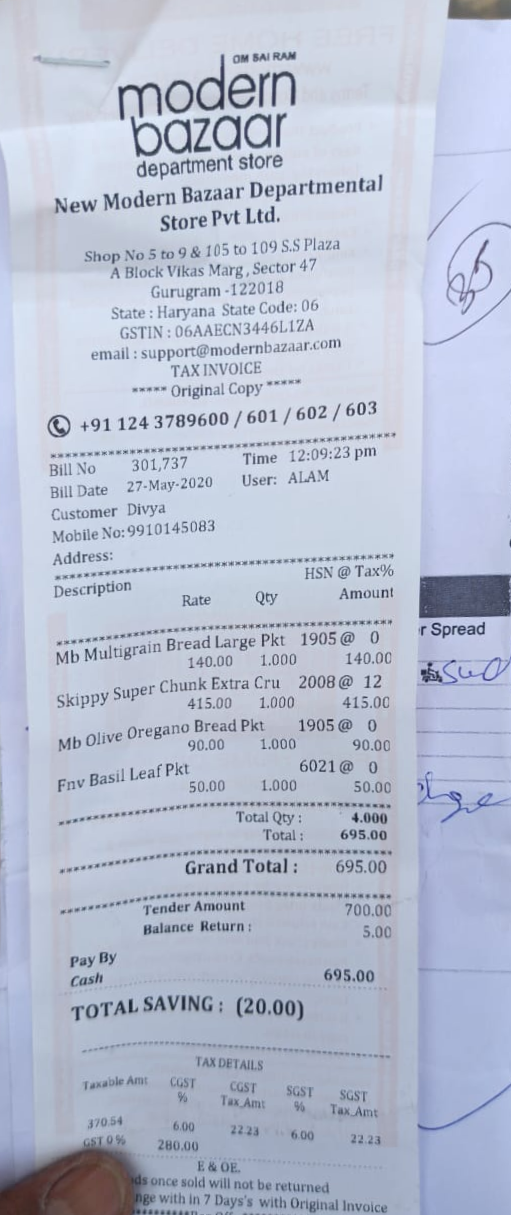





Binarised Image after perspective transformation: 




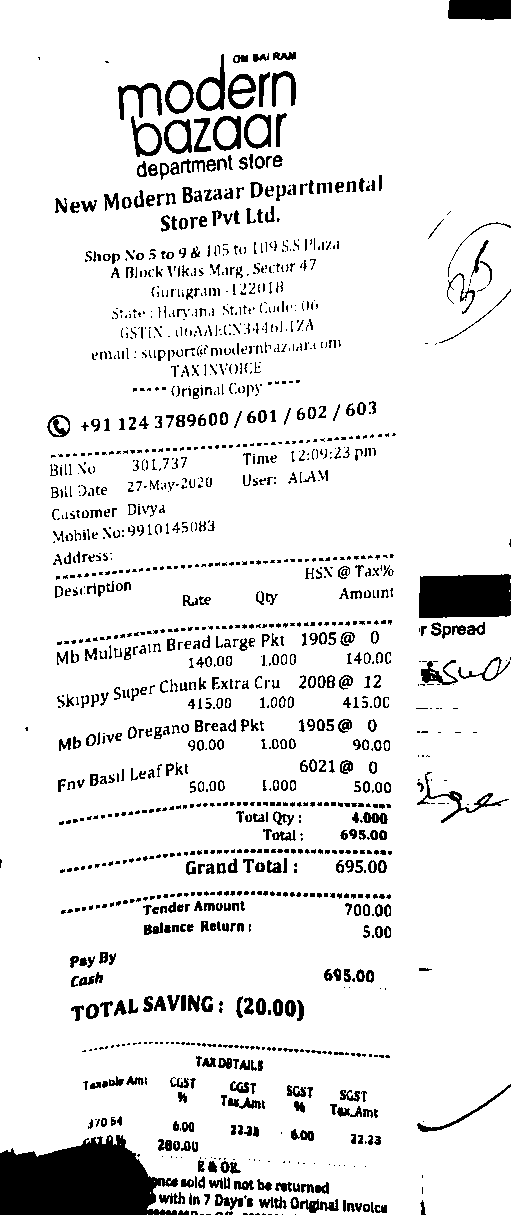

True

In [225]:
warped = four_point_transform(image_copy, coord_list)
print("Showing Warped image after PERSPECTIVE TRANSFORMATION: \n\n")
cv2_imshow(warped)
grayscale_image = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
ret, otsu_thresh_image = cv2.threshold(grayscale_image, 100, 255, cv2.THRESH_BINARY + 
                                            cv2.THRESH_OTSU)
print("\n\n\n\nBinarised Image after perspective transformation: \n\n")
cv2_imshow(otsu_thresh_image)
cv2.imwrite("warped_otsu.jpeg",otsu_thresh_image)

In [90]:
# !pip install pytesseract
# !sudo apt-get install tesseract-ocr-eng  #for english

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-eng is already the newest version (4.00~git24-0e00fe6-1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


Displaying Binarised image:



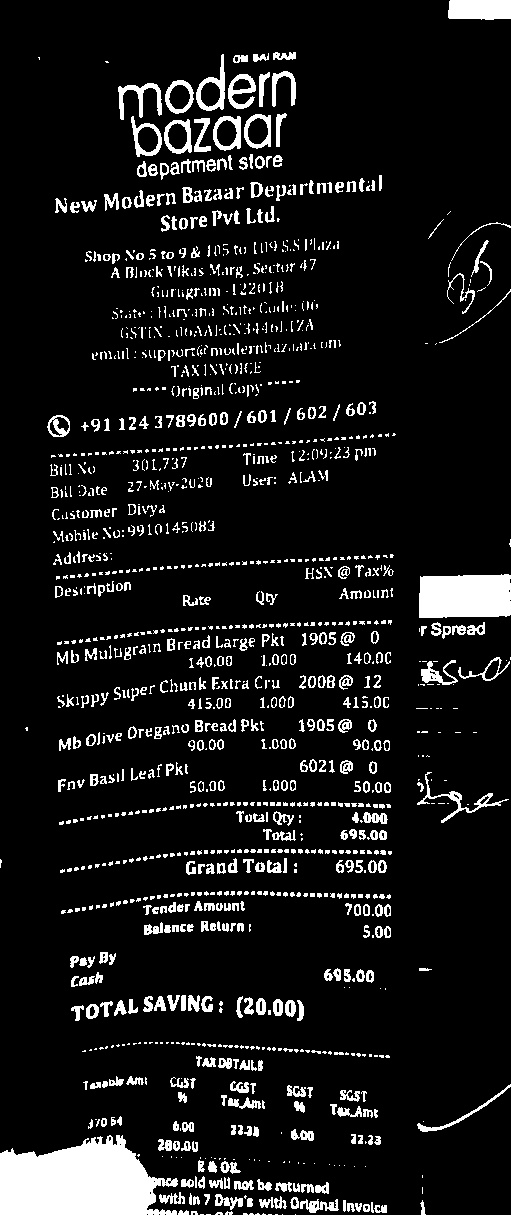





 Image with CONTOURS:




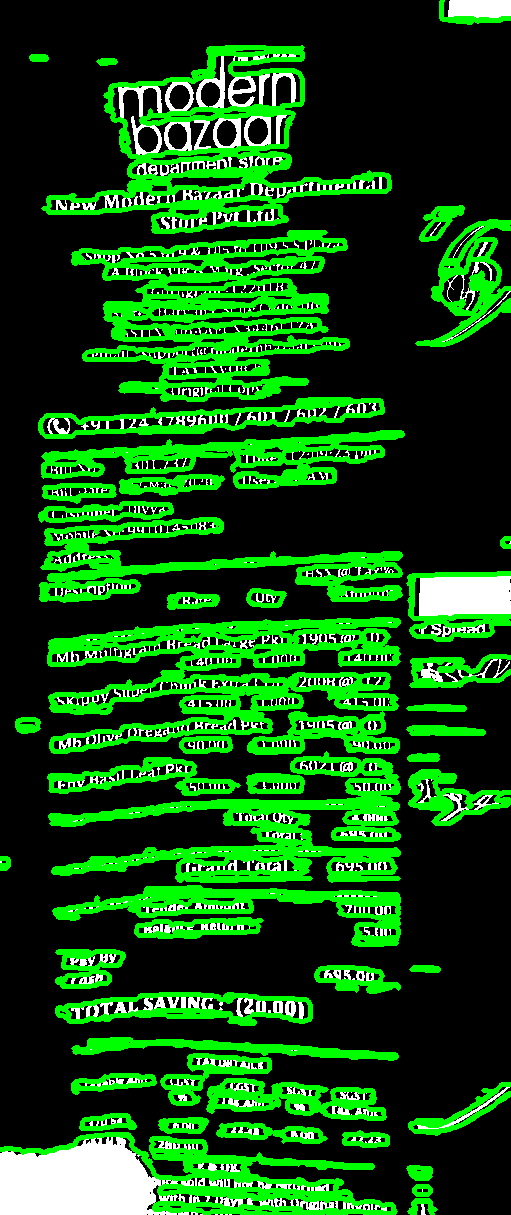





 Dilated Image with CONTOURS:




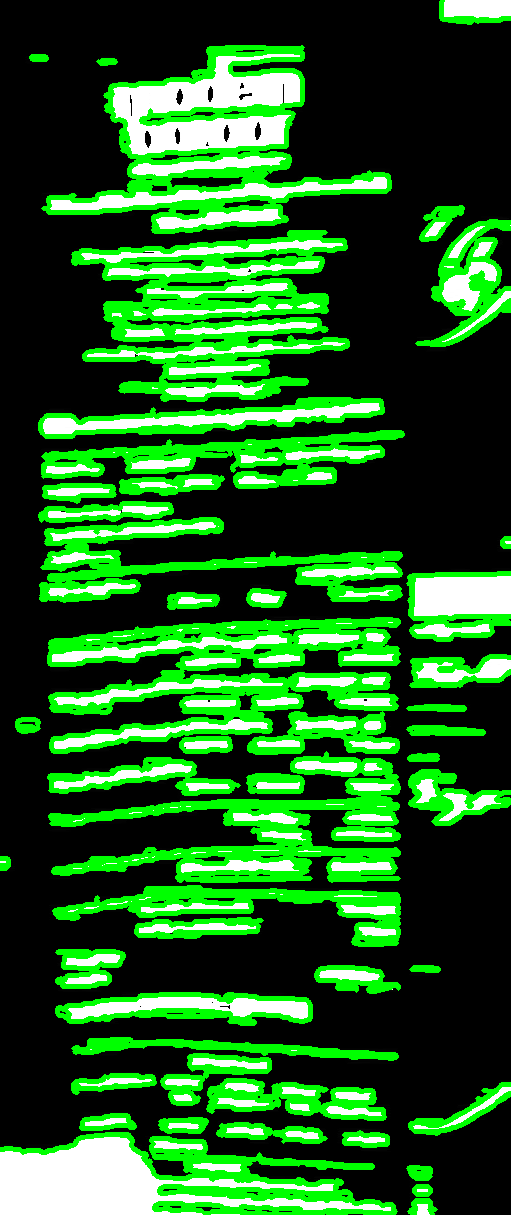

In [227]:
import pytesseract
from pytesseract import Output


img = cv2.imread('/content/warped_otsu.jpeg')
img_o = img.copy()
img = cv2.bitwise_not(img)
print("Displaying Binarised image:\n")
cv2_imshow(img)
# cv2.imwrite("otsu_image_orig.jpeg", img)
# Taking a matrix of size 5 as the kernel 
kernel = np.ones((1,15), np.uint8)
# print("kernel", kernel)
img_dilation = cv2.dilate(img, kernel, iterations=1)
CANNY= 84
edges = cv2.Canny(img_dilation, 0, CANNY, apertureSize=3)
# finding contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
# print(len(contours))
img = cv2.drawContours(img, contours, -1, (0,255,0), 3)
print("\n\n\n\n Image with CONTOURS:\n\n")
cv2_imshow(img)

img_dilated_contour = cv2.drawContours(img_dilation, contours, -1, (0,255,0), 3)
print("\n\n\n\n Dilated Image with CONTOURS:\n\n")
cv2_imshow(img_dilated_contour)
# cv2.imwrite("otsu_image_orig_dilated_contours.jpeg", img)


# #img = thresh1
# d = pytesseract.image_to_data(img_dilation, output_type=Output.DICT)
# print(d)
# n_boxes = len(d['level'])
# for i in range(n_boxes):
#   (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
#   img = cv2.rectangle(img_dilation,(x, y),(x + w, y + h),(0, 0, 255),2)

# cv2_imshow(img_dilation)
# cv2.imwrite("otsu_image_orig_dilated.jpeg", img_dilation)

In [228]:
# fields dictionary which are needed to be extracted
receipt_info = {}

In [229]:
# Configuring the tesseract model
config = ("-l eng --oem 3 --psm 6")
extracted_text_SHOP_NAME = pytesseract.image_to_string(img_o, config=config)

In [233]:
# Here according to the sample ASSUMPTION is that the name of Client is in 3rd contour. 
# Though we can come up with more optimised and generalised way after looking at different observations
name_store = extracted_text_SHOP_NAME.split("\n")[3]
print("Store Name: ", name_store)
name_store_root_name = name_store.split(" ")
print("Root name list:", name_store_root_name)
Client = name_store_root_name[1] + " " + name_store_root_name[2]
print("Client: ", Client)

Store Name:  New Modern Bazaar Departmental
Root name list: ['New', 'Modern', 'Bazaar', 'Departmental']
Client:  Modern Bazaar


In [234]:
# Client name in dictionary
receipt_info['Client'] = Client

**Though, we can directly extract all other fields from here only in this case as tesseract gave us good raw output but it is not always the case as the image orientation can be different and hence I have written below more code which allows to extract info when the first run on tesseract does not gives us good results.**
- So, we can move with cropping and zooming approach and apply tesseract on interest area

In [235]:
# extracting x, y, w, h coordinates from contours
width = []
x_coord = []
y_coord =[]
h_coord =[]
for cnt in contours:
  x,y,w,h = cv2.boundingRect(cnt)
  width.append(w)
  x_coord.append(x)
  y_coord.append(y)
  h_coord.append(h)

In [236]:
# sorting top 5 contours on basis of width as i need to find text between first two **************** lines
width_orig = width.copy()
width_sorted = width
width_sorted.sort(reverse=True)
print(width_sorted[0:5])

width_top_5_index = []
for i in range(0,5):
  index_v = width_orig.index(width_sorted[i])
  width_top_5_index.append(index_v)

print(width_top_5_index)


[360, 352, 349, 349, 348]
[109, 92, 10, 10, 48]


In [237]:
x__top_5_index = []
y__top_5_index = []
h__top_5_index = []

for i in range(0, 5):
  x__top_5_index.append(x_coord[width_top_5_index[i]])
  y__top_5_index.append(y_coord[width_top_5_index[i]])
  h__top_5_index.append(h_coord[width_top_5_index[i]])

Displaying Rectangles of identified ******** region


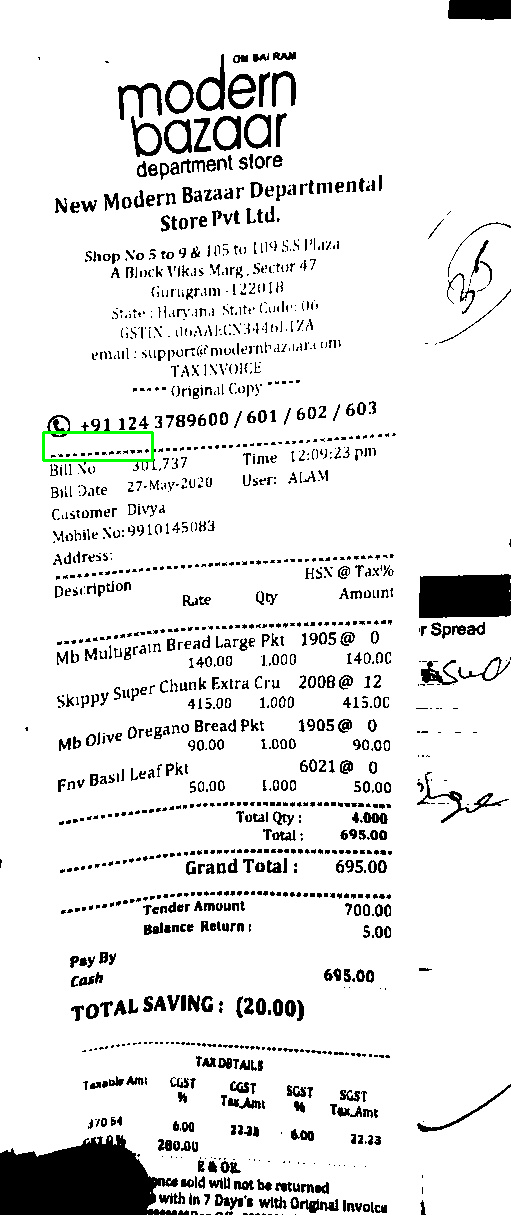

Displaying Rectangles of identified ******** region


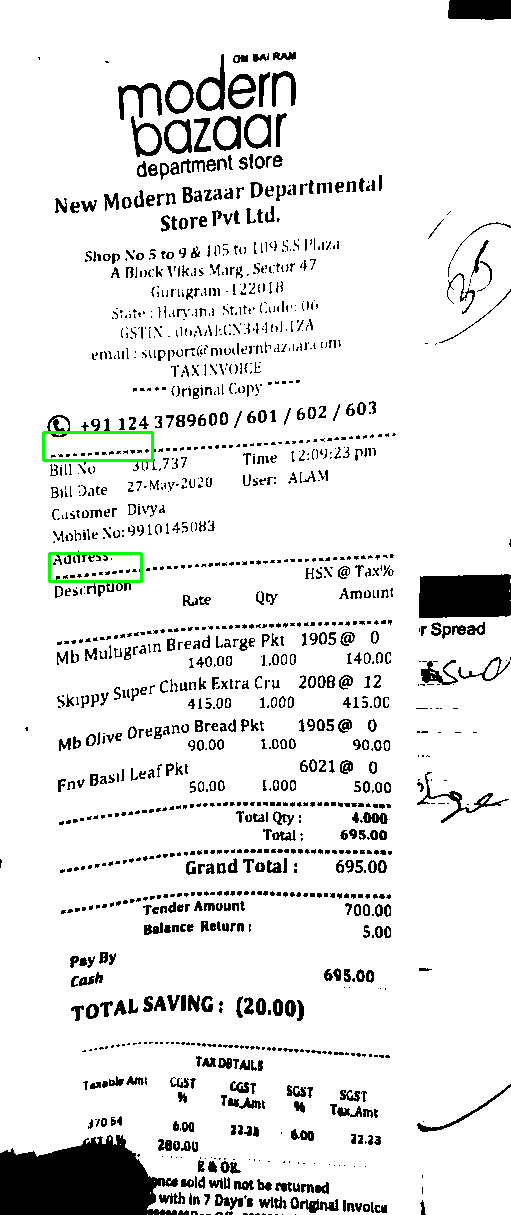

Displaying Rectangles of identified ******** region


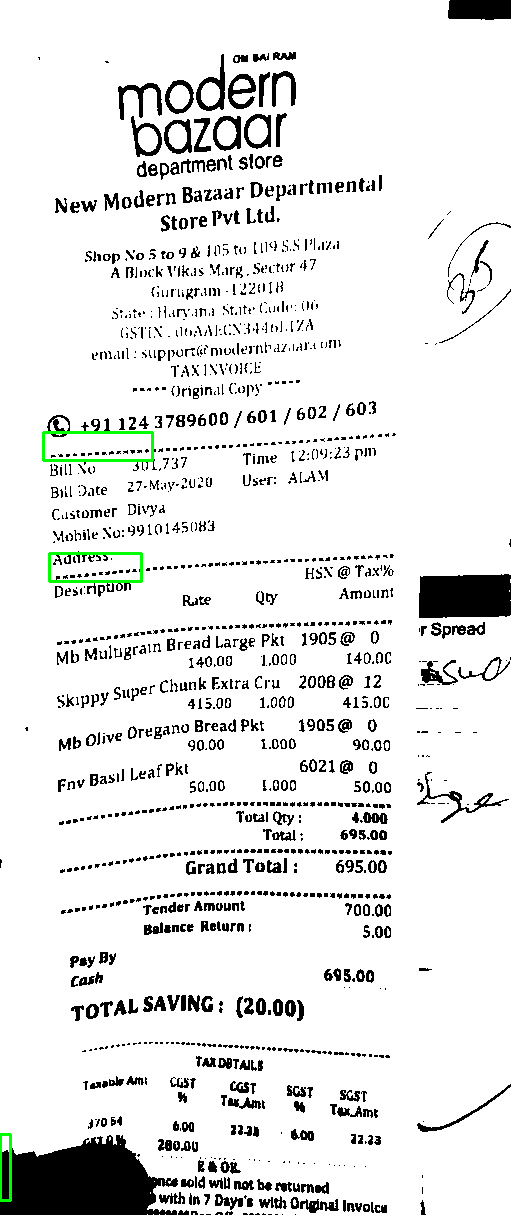

Displaying Rectangles of identified ******** region


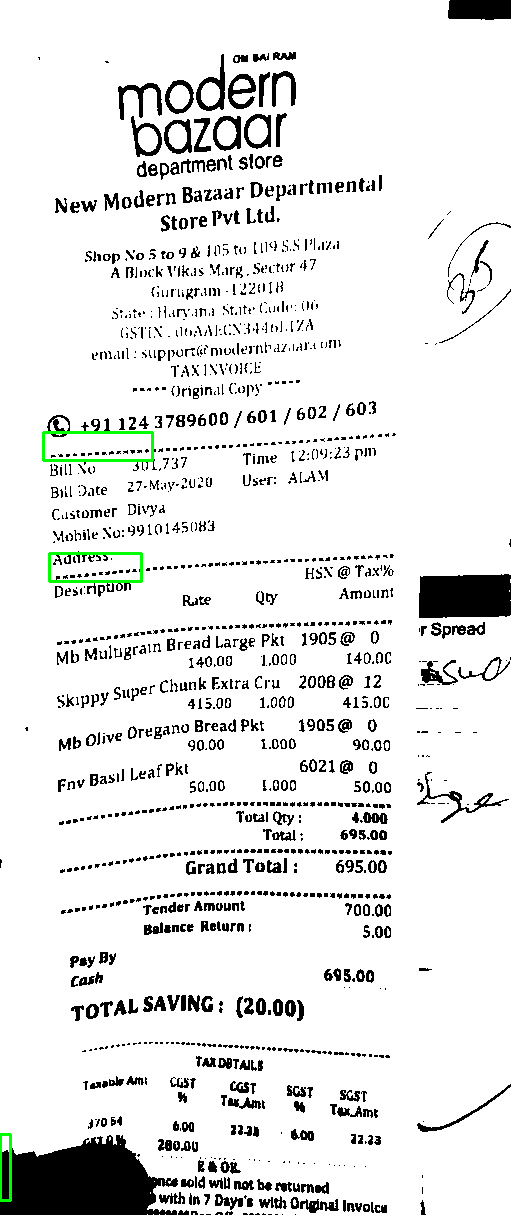

Displaying Rectangles of identified ******** region


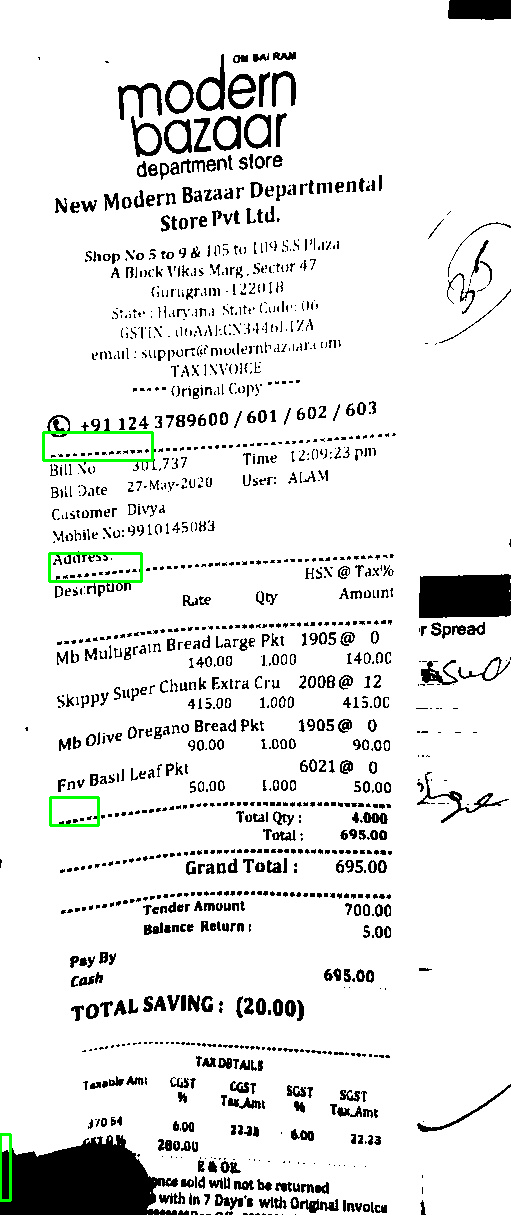

In [238]:
for i in range(0, 5):
  img_rectangle = cv2.rectangle(img_o,(x__top_5_index[i],y__top_5_index[i]),(x__top_5_index[i]+width_top_5_index[i],y__top_5_index[i]+h__top_5_index[i]),(0,255,0),2)
  print("Displaying Rectangles of identified ******** region")
  cv2_imshow(img_rectangle)
# cv2.imwrite("top_5_width_image.jpeg",img_rectangle)

y__top_5_index[0] 432
h__top_5_index[1] 28
height bw two **** 121
y__top_5_index[0]+h__top_5_index[1] 460
width **** 6
width_top_5_index[0] 109
x__top_5_index[0]+width_top_5_index[0] 152


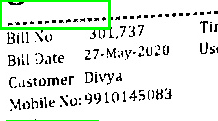

In [239]:
# Try Cropping first

# crop = img_o[y__top_5_index[0]:y__top_5_index[0]+h__top_5_index[1], 
#              x__top_5_index[0]:x__top_5_index[0]+width_top_5_index[0]]

crop = img_o[y__top_5_index[0]:y__top_5_index[0]+(y__top_5_index[1] - y__top_5_index[0]), 
             x__top_5_index[0]:x__top_5_index[0]+2*width_top_5_index[0]]


print("y__top_5_index[0]",y__top_5_index[0])
print("h__top_5_index[1]",h__top_5_index[1])
print("height bw two ****",y__top_5_index[1] - y__top_5_index[0])
print("y__top_5_index[0]+h__top_5_index[1]",y__top_5_index[0]+h__top_5_index[1])
print("width ****", x__top_5_index[1] - x__top_5_index[0])
print("width_top_5_index[0]",width_top_5_index[0])
print("x__top_5_index[0]+width_top_5_index[0]",x__top_5_index[0]+width_top_5_index[0])

cv2_imshow(crop)
# Trying Zooming
# Specify the size of image along with interploation methods. 
# cv2.INTER_AREA is used for shrinking, whereas cv2.INTER_CUBIC 
# is used for zooming. 
# res = cv2.resize(img_o, (int(width_top_5_index[0]*2), int((h__top_5_index[1] - h__top_5_index[0])*2)), interpolation = cv2.INTER_CUBIC) 
# cv2_imshow(res)

CROPPED IMAGE:



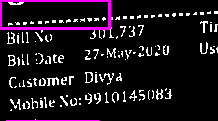





CONTOURS on CROPPED IMAGE




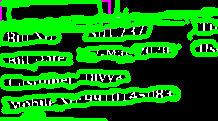





Contours on Dilated and Cropped Image


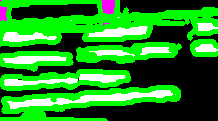

In [242]:
img_cropped = cv2.bitwise_not(crop)
img_cropped_o = img_cropped
print("CROPPED IMAGE:\n")
cv2_imshow(img_cropped)
cv2.imwrite("otsu_image_cropped.jpeg", img_cropped)
# Taking a matrix of size 5 as the kernel 
kernel = np.ones((1,15), np.uint8)
# print("kernel", kernel)
img_dilation = cv2.dilate(img_cropped, kernel, iterations=1)
CANNY= 84
edges = cv2.Canny(img_dilation, 0, CANNY, apertureSize=3)
# finding contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
# print(len(contours))
img = cv2.drawContours(img_cropped, contours, -1, (0,255,0), 3)
print("\n\n\n\nCONTOURS on CROPPED IMAGE\n\n")
cv2_imshow(img)

img_dilated_contour = cv2.drawContours(img_dilation, contours, -1, (0,255,0), 3)
print("\n\n\n\nContours on Dilated and Cropped Image")
cv2_imshow(img_dilated_contour)
# cv2.imwrite("otsu_image_cropped_dilated_contours.jpeg", img)





ZOOMED IMAGE




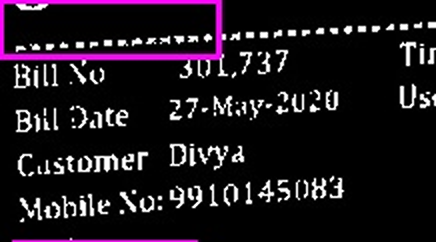

In [243]:
# Zooming image

try:
  image_new = cv2.imread("/content/otsu_image_cropped.jpeg")
  (height, width) = image_new.shape[:2]
  res = cv2.resize(image_new, (int(width*2), int(height*2)), interpolation = cv2.INTER_CUBIC)
  print("\n\n\n\nZOOMED IMAGE\n\n")
  cv2_imshow(res)
  # cv2.imwrite('result.jpeg', res) 
  
except IOError:
  print ('Error while reading files !!!') 






CONTOURS ON ZOOMED IMAGE




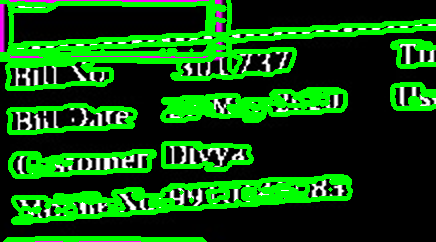





CONTOURS on DILATED ZOOMED Image




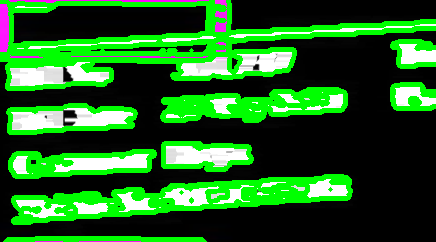

In [244]:
# Taking a matrix of size 5 as the kernel 
kernel = np.ones((1,15), np.uint8)
# print("kernel", kernel)
img_dilation = cv2.dilate(res, kernel, iterations=1)
CANNY= 84
edges = cv2.Canny(img_dilation, 0, CANNY, apertureSize=3)
# finding contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)
# print(len(contours))
img = cv2.drawContours(res, contours, -1, (0,255,0), 3)
print("\n\n\n\nCONTOURS ON ZOOMED IMAGE\n\n")
cv2_imshow(img)

img_dilated_contour = cv2.drawContours(img_dilation, contours, -1, (0,255,0), 3)
print("\n\n\n\nCONTOURS on DILATED ZOOMED Image\n\n")
cv2_imshow(img_dilated_contour)
# cv2.imwrite("otsu_image_cropped_dilated_ZOOMED_contours.jpeg", img)

In [245]:
# configuring pytesseract
config = ("-l eng --oem 3 --psm 6")
extracted_text = pytesseract.image_to_string(crop, config=config)

In [247]:
# print(extracted_text)

In [248]:
# extracted_text

In [254]:
import re
# regex for date
date = re.findall("\d{1,2}-[a-zA-Z]+?-\d{4}", extracted_text)
print(date)
if date:
  print("Yes, Date Found")
else:
  print("No match")
receipt_info["Bill Date"] = date[0]

['27-May-2020']
Yes, Date Found


In [255]:
# regex for customer name
customer = re.findall("Customer.*?\n", extracted_text)[0].replace('Customer ','').replace('\n','')
print(customer)
# print(x)
if customer:
  print("Yes, Name Found")
else:
  print("No match")

receipt_info["Customer Name"] = customer

Divya
Yes, Name Found


In [256]:
# regex for mobile number
mobile_num = re.sub('[a-zA-Z]+','',re.findall("Mobile.*", extracted_text)[0]).replace(' ','')
print(mobile_num)
# print(x)
if customer:
  print("Yes, Mobile Number Found")
else:
  print("No match")

receipt_info["Mobile No"] = mobile_num

9910145083
Yes, Mobile Number Found


In [257]:
# dictionary
receipt_info

{'Bill Date': '27-May-2020',
 'Client': 'Modern Bazaar',
 'Customer Name': 'Divya',
 'Mobile No': '9910145083'}

In [259]:
import json
receipt_info_json = json.dumps(receipt_info)
json.dump(receipt_info, open("Invoice_OCR_Output.json","w"))